# Modified TensorFlow Object Detection Tutorial
This is the [tensorflow object detection tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb) notebook modified to display the results from only one class and on a number of images. It assumes you've already downloaded the frozen inference graph.
 

In [1]:
import numpy as np
import sys
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image

#Use this to navigate to wherever your 'object_detection' folder is
sys.path.append("models/research/") 
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

/Users/Jeff/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/Jeff/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Model preparation 

In [2]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('models','research','object_detection',
                              'data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [5]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [6]:
# the original tutorial tests on two images within the test_images folder
# PATH_TO_TEST_IMAGES_DIR = 'models/research/object_detection/test_images'
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# I am using frames generated from openCV (see get_frames.ipynb)

# wearing white jerseys
frame_nums = [295,546,680,1405,1607,2191]
# frame_nums = range(1540,1668)
# wearing blue jerseys
# frame_nums = [10,250,492,601,612,672,1429,1573,1694]
PATH_TO_TEST_IMAGES_DIR = 'frames_white'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame{}.jpg'.format(i)) for i in frame_nums ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [7]:
# this cell only modified as indicated below

def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
      
      # MODIFIED ------------------------------------------------
      #only include person class:
      output_dict['detection_boxes'] = output_dict[
          'detection_boxes'][output_dict['detection_classes']==1]
      output_dict['detection_scores'] = output_dict[
          'detection_scores'][output_dict['detection_classes']==1]
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][output_dict['detection_classes']==1]
      # ----------------------------------------------------------

  return output_dict

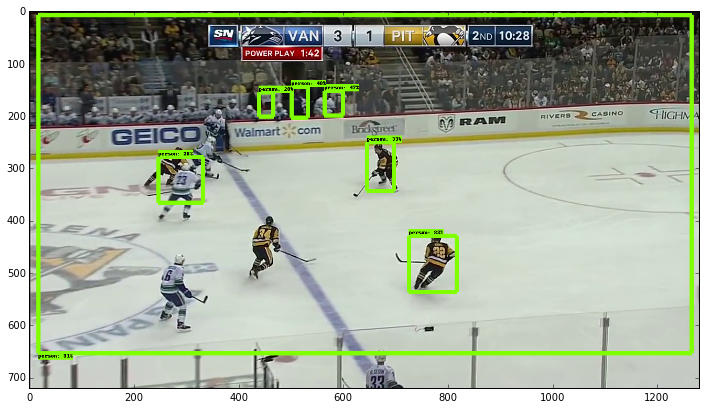

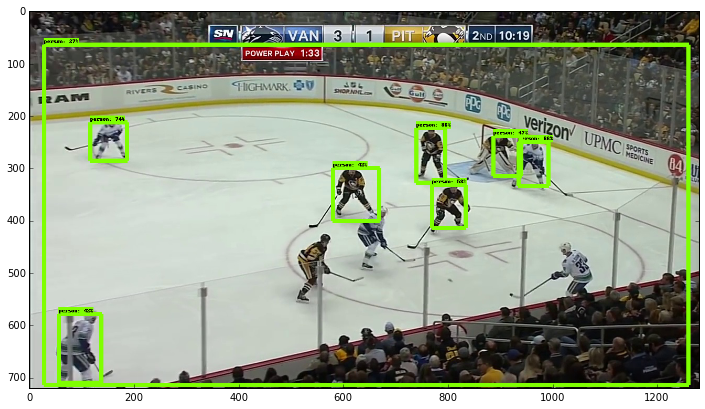

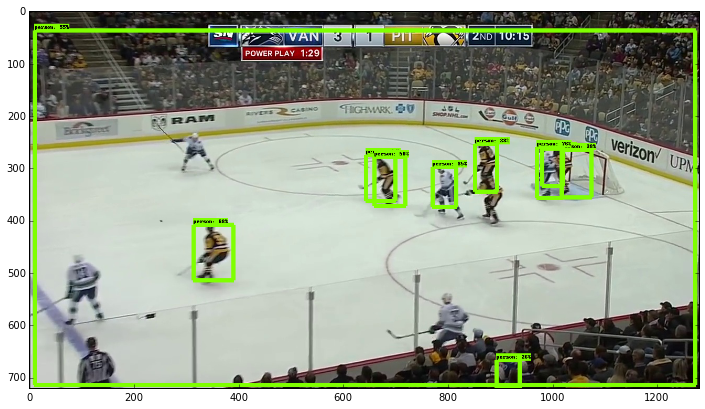

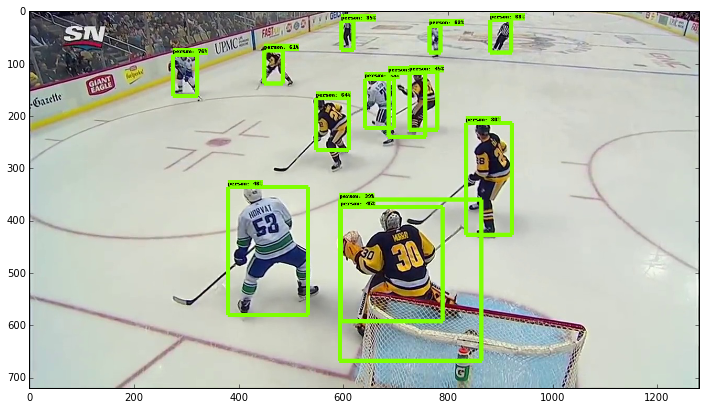

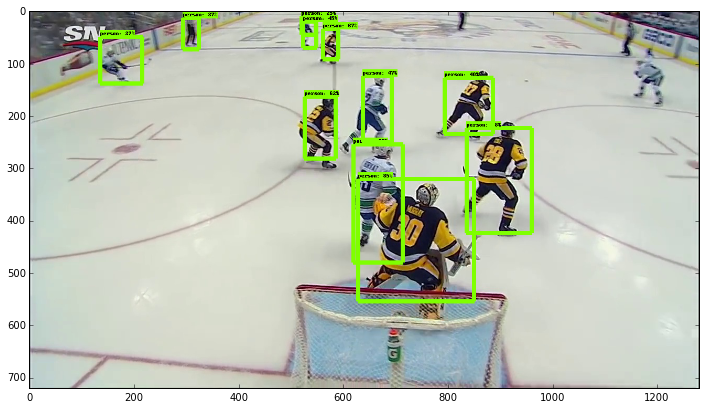

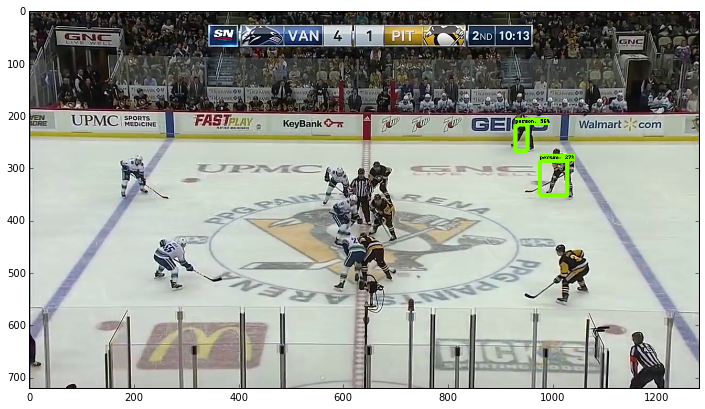

In [8]:
k=0
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.25) 
  # Because few of persons were being detected at 0.5, I added min_score_thresh=0.25 above
#   plt.imsave('{:03d}.png'.format(k), image_np) #if you want to save images
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  k+=1

In [9]:
# if you want to look at the detection classes and probabilities for individual images
oc_names = [dict(category_index[oc])['name'].encode("utf-8") 
            for oc in output_dict['detection_classes']]
top = zip(output_dict['detection_scores'][0:25],oc_names[0:25])
display(top)

[(0.56762451, 'person'),
 (0.27633932, 'person'),
 (0.23595946, 'person'),
 (0.23280199, 'person'),
 (0.22678342, 'person'),
 (0.20330131, 'person'),
 (0.184028, 'person'),
 (0.16043478, 'person'),
 (0.14481124, 'person'),
 (0.13798317, 'person'),
 (0.13741246, 'person'),
 (0.13695297, 'person'),
 (0.13071559, 'person'),
 (0.12885445, 'person'),
 (0.12628321, 'person'),
 (0.12291542, 'person'),
 (0.12263715, 'person'),
 (0.1129991, 'person'),
 (0.11251639, 'person'),
 (0.11034721, 'person'),
 (0.10703677, 'person'),
 (0.1069874, 'person'),
 (0.10216035, 'person'),
 (0.10113774, 'person'),
 (0.10053873, 'person')]